In [1]:
import sys,os
from direct_info import direct_info
from direct_info import sort_di

import expectation_reflection as ER
import data_processing as dp
from joblib import Parallel, delayed
import ecc_tools as tools
import timeit

import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder

# Import pydca module to read and and preprocess msa
from pydca.fasta_reader import fasta_reader
from pydca.meanfield_dca import meanfield_dca
from pydca.sequence_backmapper import sequence_backmapper
from pydca.msa_trimmer import msa_trimmer
from pydca.msa_trimmer.msa_trimmer import MSATrimmerException
from pydca.dca_utilities import dca_utilities

import numpy as np
import pickle

# Import Bio data processing features 
import Bio.PDB, warnings
from Bio.PDB import *
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning

# Set warning filters
warnings.filterwarnings("error")
warnings.simplefilter('ignore', BiopythonWarning)
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', ResourceWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [2]:
# Define DI and MSA utility functions

def delete_sorted_DI_duplicates(sorted_DI):
    temp1 = []
    print(sorted_DI[:10])
    DI_out = dict() 
    for (a,b), score in sorted_DI:
        if (a,b) not in temp1 and (b,a) not in temp1: #to check for the duplicate tuples
            temp1.append(((a,b)))
            if a>b:
                DI_out[(b,a)]= score
            else:
                DI_out[(a,b)]= score
    DI_out = sorted(DI_out.items(), key = lambda k : k[1], reverse=True)
    #DI_out.sort(key=lambda x:x[1],reverse=True) 
    return DI_out 


# from pydca/pydca/erdca.py
def replace_gaps(s0,ref_seq):
    amino_acid_ints = [ 1,  2,  3, 4, 5, 6, 7, 8, 9,  10, 11, 12, 13, 14, 15,16,  17, 18, 19, 20]
    s0_nogap = s0
    for i,seq in enumerate(s0):
        #print('\n',seq)
        for ii,aa in enumerate(seq):
            if aa  == 21:
                #s0_nogap[i,ii] = random.choice(s0[:,ii][s0[:,ii]!= 21])
                s0_nogap[i,ii] = refseq[ii]
    #print('at %d replace %d with %d '% (ii,aa,self.__refseq[ii]))
    #print(s0_nogap[i],'\n')
    return s0_nogap

data_path = '/home/eclay/Pfam-A.full'
preprocess_path = '/home/eclay/DCA_ER/biowulf/pfam_ecc/'

In [3]:
# Define Simulation Parameters
pfam_id = 'PF03456' # best socre by ER
# AUC should be ~.981436
pfam_id = 'PF00186' # best socre by ER


cpus_per_job = 8

print("Calculating DI for %s using %d (of %d) threads "%(pfam_id,cpus_per_job-4,cpus_per_job))

                                               


Calculating DI for PF00186 using 4 (of 8) threads 


## Read in PDB Structure and Make Reference Sequence

In [4]:
# Read in Reference Protein Structure
pdb = np.load('%s/%s/pdb_refs.npy'%(data_path,pfam_id))                                                                                                                   
# convert bytes to str (python 2 to python 3)                                                                       
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0])      for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])
ipdb = 0
tpdb = int(pdb[ipdb,1])
print('Ref Sequence # should be : ',tpdb-1)

# Load Multiple Sequence Alignment
s = dp.load_msa(data_path,pfam_id)

# Load Polypeptide Sequence from PDB as reference sequence
print(pdb[ipdb,:])
pdb_id = pdb[ipdb,5]                                                                              
pdb_chain = pdb[ipdb,6]                                                                           
pdb_start,pdb_end = int(pdb[ipdb,7]),int(pdb[ipdb,8])                                             
pdb_range = [pdb_start-1, pdb_end]
#print('pdb id, chain, start, end, length:',pdb_id,pdb_chain,pdb_start,pdb_end,pdb_end-pdb_start+1)                        

#print('download pdb file')                                                                       
pdb_file = pdb_list.retrieve_pdb_file(str(pdb_id),file_format='pdb')                              
#pdb_file = pdb_list.retrieve_pdb_file(pdb_id)     

chain = pdb_parser.get_structure(str(pdb_id),pdb_file)[0][pdb_chain] 
ppb = PPBuilder().build_peptides(chain)                                                       
#    print(pp.get_sequence())
print('peptide build of chain produced %d elements\n\n'%(len(ppb)))                               

matching_seq_dict = {}
poly_seq = list()
for i,pp in enumerate(ppb):
    for char in str(pp.get_sequence()):
        poly_seq.append(char)                                     
print('PDB Polypeptide Sequence: \n',poly_seq)

poly_seq_range = poly_seq[pdb_range[0]:pdb_range[1]]
print('PDB Polypeptide Sequence (In Proteins PDB range len=%d): \n'%len(poly_seq_range),poly_seq_range)

pp_msa_file_range, pp_ref_file_range = tools.write_FASTA(poly_seq_range, s, pfam_id, number_form=False,processed=False,path='./pfam_ecc/',nickname='range')

pp_msa_file, pp_ref_file = tools.write_FASTA(poly_seq, s, pfam_id, number_form=False,processed=False,path='./pfam_ecc/')


Ref Sequence # should be :  68
shape of s (import from msa.npy):
 (7750, 918)
shape of s (after UTF-8 decode):
 (7750, 918)
['PF00186' '69' 'Q5KZ26_GEOKA' '1' '160' '1ZDR' 'B' '1' '160']
Structure exists: '/home/eclay/DCA_ER/zd/pdb1zdr.ent' 
peptide build of chain produced 1 elements


PDB Polypeptide Sequence: 
 ['M', 'I', 'S', 'H', 'I', 'V', 'A', 'M', 'D', 'E', 'N', 'R', 'V', 'I', 'G', 'K', 'D', 'N', 'R', 'L', 'P', 'W', 'H', 'L', 'P', 'A', 'D', 'L', 'A', 'Y', 'F', 'K', 'R', 'V', 'T', 'M', 'G', 'H', 'A', 'I', 'V', 'M', 'G', 'R', 'K', 'T', 'F', 'E', 'A', 'I', 'G', 'R', 'P', 'L', 'P', 'G', 'R', 'D', 'N', 'V', 'V', 'V', 'T', 'G', 'N', 'R', 'S', 'F', 'R', 'P', 'E', 'G', 'C', 'L', 'V', 'L', 'H', 'S', 'L', 'E', 'E', 'V', 'K', 'Q', 'W', 'I', 'A', 'S', 'R', 'A', 'D', 'E', 'V', 'F', 'I', 'I', 'G', 'G', 'A', 'E', 'L', 'F', 'R', 'A', 'T', 'M', 'P', 'I', 'V', 'D', 'R', 'L', 'Y', 'V', 'T', 'K', 'I', 'F', 'A', 'S', 'F', 'P', 'G', 'D', 'T', 'F', 'Y', 'P', 'P', 'I', 'S', 'D', 'D', 'E', 'W', 'E', 'I',

## Pre-Process (trim) FASTA MSA

In [5]:
trimmed_data_outfile = preprocess_path+'MSA_%s_Trimmed.fa'%pfam_id
pfam_dict ={}

print('Pre-Processing MSA')
try:
    print('\n\nPre-Processing MSA with Range PP Seq\n\n')
    trimmer = msa_trimmer.MSATrimmer(
        pp_msa_file_range, biomolecule='PROTEIN', 
        refseq_file=pp_ref_file_range
    )
    pfam_dict['ref_file'] = pp_ref_file_range
except:
    print('\nDidnt work, using full PP seq\nPre-Processing MSA wth PP Seq\n\n')

    
# Adding the data_processing() curation from tools to erdca.
try:
    trimmed_data = trimmer.get_msa_trimmed_by_refseq(remove_all_gaps=True)
    print('\n\nTrimmed Data: \n',trimmed_data[:10])

except(MSATrimmerException):
    ERR = 'PPseq-MSA'
    print('Error with MSA trimms\n%s\n'%ERR)
        
    
#write trimmed msa to file in FASTA format
with open(trimmed_data_outfile, 'w') as fh:
    for seqid, seq in trimmed_data:
        fh.write('>{}\n{}\n'.format(seqid, seq))
fh.close()

Pre-Processing MSA


Pre-Processing MSA with Range PP Seq


Best Matching Sequences:  ['--------------------------------------------MISHI-V-A-M-----D-----E-----N-----R-----V-I----G--K------D------N-----R------L----P---W--------H------L-----P------A-----D-----L---A--Y--F-------K-R---------------V-T-------------M--------------G-----------------H----------------A-----------------I--V-M-GR---KTF--E------A-I-G------------R---------PL-------P------G-----R-------D-----N---V-----VV-T----RN-RS----------------FRP------------------E---G------------CL----------VL----H-----S------L--E---EVK------------------------------------Q---WI--ASR-------ADEVF-II-----------GG-A-E-L----FR-A--T--M------------P----------I------------V---D------------------RLYV----TKIF-------------AS---F-----P-----G-----D----------T-----F----Y---------P-----P----I------S-D-------D----E-----W-E---I--V-----S---Y-----T---P-----G---G----K----D---EK----------NPY-EHAFIIYER-----------------------------------------------------------------



Trimmed Data: 
 [('PF00186', 'MISFVYAQESRGGIGYQNQLPWHLPNDLKFFKETTMGHTMLMGRKTFESMGRLLPGRKTIVMTRDLNYGKEGLTVIHRLEEGLELAKDQ--ELMVIGGADIFKLFLPYADQIIRTLIEREFPSDVFMPAIDETEWQLVKVVAGILDENNTIPHQYEWWER'), ('PF00186', '-LALVVAYSDNRVIGRDNALPWKLPGDLAHFKRTTLGSPIIMGRKTWESLGRPLPGRANIVISRNLQYSAPGAQVVPTLQAAVAACGAV-DDAYVIGGAQIYAQALPLAQRIIATEVHAQVEGDAFFPLLPSFAWREASRQPQP--PENGYAYDFVVYER'), ('PF00186', '---VVAATSSALGIGKSGGLPWRLRKEMAYFAKITTANAVIMGRKCWESIPRPLKGRVNVVISRAEKMELEHVYHVRSLPAALELLQKLLHHVFVIGGAQIYNAAMPESNRILFTAIENDFECDTYFPDFRKSGWEKKTQEELE----------------'), ('PF00186', '-LTLIVARARNGVIGRDNQLPWRLPEDLAFFKRTTMGAPIIMGRKTHESIGRPLPGRRNIVVTRDSTLRFEGCDTVTSIDDALALAAADAAEAFVIGGAQLYGDAIGRARKMIVTEIDADFDGNTRFEAPDASQWREVSREPHRAAPPNDFGFAFVTYER'), ('PF00186', 'MIALIAACDRHRLIGDHGRIPWRIPGEQARFQKLTTGHVVIMGRQTYAEIGRPLPRRQTIVLSRNQTFRAPGCRIAASLAEALRLGAAFSDQLFIAGGAAVYSKALPLADVLYLTEIDAAYVGDTYFPAFDPALFTKTLDAHISGD--------------'), ('PF00186', 'MISIIVAIGKNNEIGKKNDLLWSLPADMKHFKETTKGRTVIMGQKTFESLARLLPNRRNIIITQDNSFKKEGAEVVYSVDELM

In [6]:
# Load trimmed data (the way its done in pydca) for ER calculation
ref_seq_array = fasta_reader.get_alignment_int_form(pp_ref_file_range,biomolecule='Protein')
refseq = ref_seq_array[0]

sequences = fasta_reader.get_alignment_int_form(trimmed_data_outfile,biomolecule='Protein')

s0 = np.asarray(sequences)
print('\ns0 first row:\n',s0[0])
print('s0 shape:',s0.shape,'\n')

# replace gaps (as done in erdca)
s0 = replace_gaps(s0,refseq)
print('    after replacing gaps...\n    s0 shape:',s0.shape)

n_var = s0.shape[1]
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])
mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T 

#onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
onehot_encoder = OneHotEncoder(sparse=False)

s = onehot_encoder.fit_transform(s0)

mx_sum = mx.sum()
my_sum = mx.sum() #!!!! my_sum = mx_sum




s0 first row:
 [11  8 16  5 18 20  1 14  4 16 15  6  6  8  6 20 14 12 14 10 13 19  7 10
 13 12  3 10  9  5  5  9  4 17 17 11  6  7 17 11 10 11  6 15  9 17  5  4
 16 11  6 15 10 10 13  6 15  9 17  8 18 11 17 15  3 10 12 20  6  9  4  6
 10 17 18  8  7 15 10  4  4  6 10  4 10  1  9  3 14 21 21  4 10 11 18  8
  6  6  1  3  8  5  9 10  5 10 13 20  1  3 14  8  8 15 17 10  8  4 15  4
  5 13 16  3 18  5 11 13  1  8  3  4 17  4 19 14 10 18  9 18 18  1  6  8
 10  3  4 12 12 17  8 13  7 14 20  4 19 19  4 15]
s0 shape: (7544, 160) 

    after replacing gaps...
    s0 shape: (7544, 160)


## Generate ER Initial couplings 
- From DCA calculation
- Create MF instance and feed couplings as initial ER couplings

In [7]:
num_site_states = 21 # 21 possible aa states (including '-')
# MF instance 
mfdca_inst = meanfield_dca.MeanFieldDCA(
    trimmed_data_outfile,
    'protein',
    pseudocount = 0.5,
    seqid = 0.8,
)

reg_fi = mfdca_inst.get_reg_single_site_freqs()
reg_fij = mfdca_inst.get_reg_pair_site_freqs()
corr_mat = mfdca_inst.construct_corr_mat(reg_fi, reg_fij)
couplings = mfdca_inst.compute_couplings(corr_mat)
print('DCA couplings shape: ', couplings.shape)
fields_ij = mfdca_inst.compute_two_site_model_fields(couplings, reg_fi)
print('DCA fields shape: ', fields_ij.shape)

DCA couplings shape:  (3200, 3200)
DCA fields shape:  (12720, 2, 21)


#### Transform DCA couplins (full aa states per position) to fit ER

In [8]:
unique_states = np.array([np.unique(s0[:,i]) for i in range(n_var)])
non_states = []
unique_aminos = []
for states in unique_states: 
	unique_aminos.append(states[states!=21]) #DCA couplings calculation doesn't include '-' states
#print('uniqe_aminos[0]:\n',unique_aminos[0])


col = 0
for i in range(n_var):
	for j in range(1,num_site_states):
		if j not in unique_aminos[i]:
			non_states.append(col)
		col += 1
print('deleting %d colums/rows of %d, column/row count should be %d '%(len(non_states),col,s.shape[1]))
er_couplings = np.delete(couplings,non_states,axis=0)
er_couplings = np.delete(er_couplings,non_states,axis=1)

#np.save('pfam_ecc/%s_ER_couplings.npy'%(pfam_id),er_couplings)
print('ER couplings shape: ', er_couplings.shape)

deleting 353 colums/rows of 3200, column/row count should be 2847 
ER couplings shape:  (2847, 2847)


## Run ER Simulation
- Define ER functions
- Run ER for Pfam

In [9]:
# Define prediction function

w = np.zeros((mx_sum,my_sum))
h0 = np.zeros(my_sum)

#=========================================================================================
def predict_w(s,i0,i1i2,niter_max,l2,couplings = None):
    #print('i0:',i0)
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    x = np.hstack([s[:,:i1],s[:,i2:]])
    y = s[:,i1:i2]

    if couplings is None:
        # Using expectiation_reflection.py from biowulf/expectation_reflection.py
        h01,w1 = ER.reg_fit(x,y,niter_max,l2) # ER.reg_fit is regularized Expectation Reflection
    else:
        y_couplings = np.delete(couplings,[range(i1,i2)],0)	# remove subject rows  from original coupling matrix 
        y_couplings = np.delete(y_couplings,[range(i1,i2)],1)   # remove subject columns from original coupling matrix 
        h01,w1 = ER.reg_fit(x,y,niter_max,l2,y_couplings)
        
    return h01,w1

In [10]:
# parallel
res = Parallel(n_jobs = cpus_per_job - 4)(delayed(predict_w)\
        (s,i0,i1i2,niter_max=10,l2=100.0,couplings = None)\
        for i0 in range(n_var))

#-------------------------------
for i0 in range(n_var):
    i1,i2 = i1i2[i0,0],i1i2[i0,1]
       
    h01 = res[i0][0]
    w1 = res[i0][1]

    h0[i1:i2] = h01    
    w[:i1,i1:i2] = w1[:i1,:]
    w[i2:,i1:i2] = w1[i1:,:]

# make w to be symmetric
w = (w + w.T)/2.
di = direct_info(s0,w)



sorted_DI_er = sort_di(di)

sorted_DI_er = delete_sorted_DI_duplicates(sorted_DI_er)

[((12, 122), 0.015690827850719947), ((122, 12), 0.015690827850719947), ((50, 49), 0.013878811006033203), ((49, 50), 0.013878811006033203), ((55, 35), 0.007575405597502219), ((35, 55), 0.007575405597502219), ((100, 61), 0.007168851864717387), ((61, 100), 0.007168851864717387), ((136, 139), 0.00674420182256389), ((139, 136), 0.00674420182256389)]


## Save, and Plot Results

In [11]:

with open('er_DI_%s.pickle'%(pfam_id), 'wb') as f:
    pickle.dump(sorted_DI_er, f)
f.close()# Save processed data dictionary and FASTA file
print('s shape (msa): ',s.shape)
pfam_dict['msa'] = s  
pfam_dict['processed_msa'] = trimmed_data 
pfam_dict['s_ipdb'] = tpdb
pfam_dict['cols_removed'] = []

input_data_file = preprocess_path+"%s_DP_ER_clean.pickle"%(pfam_id)
with open(input_data_file,"wb") as f:
	pickle.dump(pfam_dict, f)
f.close()

# Print resulting DI score
print('Top 10  DIs')
for site_pair, score in sorted_DI_er[:10]:
    print(site_pair, score)

#---------------------------------------------------------------------------------------------------------------------# 

s shape (msa):  (7544, 2847)
Top 10  DIs
(12, 122) 0.015690827850719947
(49, 50) 0.013878811006033203
(35, 55) 0.007575405597502219
(61, 100) 0.007168851864717387
(136, 139) 0.00674420182256389
(149, 150) 0.006437310599630071
(78, 104) 0.0064169604712395936
(37, 93) 0.006201878973287159
(39, 58) 0.006085626350026322
(7, 11) 0.005785131336699839


Using chain  B
PDB ID:  1ZDR
NEW VERSION
((12, 122), (35, 55), (61, 100), (78, 104), (37, 93), (39, 58), (5, 113), (20, 122), (57, 73), (9, 117), (91, 112), (2, 112), (47, 67), (3, 108), (62, 76), (113, 157), (111, 129), (46, 72), (63, 99), (40, 81), (52, 58), (5, 27), (4, 101), (101, 126), (5, 126), (38, 55), (8, 122), (50, 122), (151, 156), (136, 155), (20, 101), (40, 59), (17, 50), (46, 58), (58, 95), (2, 91), (22, 27), (147, 152), (37, 91), (116, 124), (5, 13), (38, 59), (49, 72), (105, 129), (3, 94), (149, 155), (81, 104), (39, 46), (61, 104), (62, 99), (98, 124), (142, 152), (13, 122), (12, 20), (46, 51), (11, 17), (31, 54), (115, 155), (149, 156), (46, 52), (40, 92), (8, 101), (44, 99), (19, 27), (139, 155), (23, 144), (63, 100), (27, 54), (29, 156), (5, 11), (5, 111), (17, 126), (116, 152), (150, 156), (5, 49), (112, 156), (12, 125), (144, 151), (49, 58), (2, 11), (50, 91), (19, 116), (21, 122), (50, 112), (50, 126), (91, 110), (4, 17), (93, 112), (7, 20), (101, 116), (29, 112)

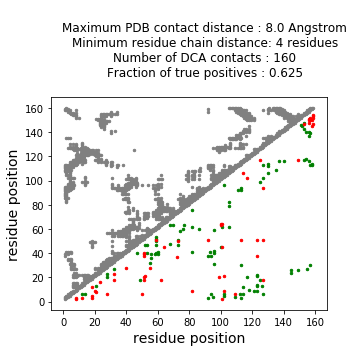

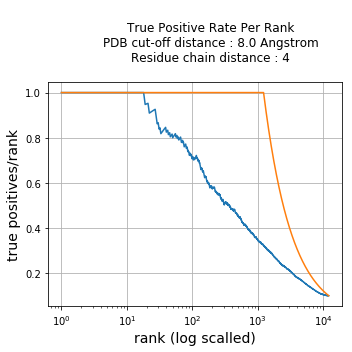

In [12]:
# Print Details of protein PDB structure Info for contact visualizeation
print('Using chain ',pdb_chain)
print('PDB ID: ', pdb_id)

from pydca.contact_visualizer import contact_visualizer

visualizer = contact_visualizer.DCAVisualizer('protein', pdb_chain, pdb_id,
refseq_file = pp_ref_file,
sorted_dca_scores = sorted_DI_er,
linear_dist = 4,
contact_dist = 8.)

contact_map_data = visualizer.plot_contact_map()
plt.show()
#plt.close()
tp_rate_data = visualizer.plot_true_positive_rates()
plt.show()
#plt.close()
#print('Contact Map: \n',contact_map_data[:10])
#print('TP Rates: \n',tp_rate_data[:10])

with open(preprocess_path+'ER_%s_contact_map_data.pickle'%(pfam_id), 'wb') as f:
    pickle.dump(contact_map_data, f)
f.close()

with open(preprocess_path+'ER_%s_tp_rate_data.pickle'%(pfam_id), 'wb') as f:
    pickle.dump(tp_rate_data, f)
f.close()

peptide build of chain produced 1 elements


Loading CA coordintates from polypeptid sequence (ref_seq)
PF00186 AUC: 0.800551


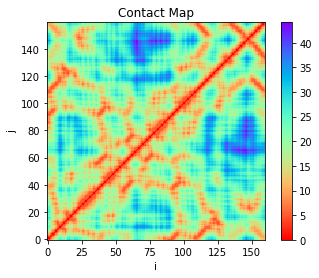

In [13]:
#---------------------------------------------------------------------------------------------------------------------#
# Get AUC using roc_curve from tools..
#---------------------------------------------------------------------------------------------------------------------#            
print('peptide build of chain produced %d elements\n\n'%(len(ppb)))                               
print('Loading CA coordintates from polypeptid sequence (ref_seq)')
coords_all = np.array([a.get_coord() for a in chain.get_atoms()])
ca_residues = np.array([a.get_name()=='CA' for a in chain.get_atoms()])
ca_coords = coords_all[ca_residues]

ct_thres = np.linspace(1.5,10.,18,endpoint=True)
n = ct_thres.shape[0]

distance_mat = distance_matrix(ca_coords,ca_coords)
#--------------------------------------------------------------------------------#            


di_matrix = np.zeros(distance_mat.shape)
for coupling in sorted_DI_er:                                                                          
    di_matrix[coupling[0][0],coupling[0][1]] = coupling[1]                                               
    di_matrix[coupling[0][1],coupling[0][0]] = coupling[1]

auc_ct_thresh = np.zeros(n)
for ii,ct_threshold in enumerate(ct_thres):
    #ct = distance_mat[distance_mat < ct_threshold]
    p,tp,fp = tools.roc_curve(distance_mat , di_matrix ,ct_threshold)
    auc_ct_thresh[ii] = tp.sum()/tp.shape[0] 
i0 = np.argmax(auc_ct_thresh)

p,tp,fp = tools.roc_curve(distance_mat , di_matrix ,ct_thres[i0])
AUC = tp.sum()/tp.shape[0]

print('%s AUC: %f'%(pfam_id,AUC))
#---------------------------------------------------------------------------------------------------------------------#            
plt.title('Contact Map')
plt.imshow(distance_mat,cmap='rainbow_r',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.colorbar(fraction=0.045, pad=0.05)
plt.show()


In [14]:
# Plot AUC 
plt.plot(fp,tp,'b-',label="er")
#plt.plot(fp0_old_mf,tp0_old_mf,'r-',label="mf")
#plt.plot(fp0_old_plm,tp0_old_plm,'g-',label="plm")
plt.plot([0,1],[0,1],'k--')
plt.set_xlim([0,1])
plt.set_ylim([0,1])
plt.set_xlabel('False Positive Rate')
plt.set_ylabel('True Positive Rate')
plt.set_title('ROC ')
plt.legend()
plt.show()

SyntaxError: invalid syntax (<ipython-input-14-3977fc625eef>, line 7)